# Plot SARI timeseries

In [1]:
from src.realtime_utils import *
from plotnine import *

# Load data

In [2]:
targets, covariates = load_realtime_training_data()

In [3]:
train_end = pd.Timestamp('2022-10-02')
validation_end = pd.Timestamp('2023-11-16')
test_end = pd.Timestamp('2024-10-06')

In [4]:
highlight_areas = pd.DataFrame({
    "xmin": [targets.start_time(), train_end, validation_end],
    "xmax": [train_end, validation_end, test_end],
    "period": ["Train", "Validation", "Test"]  
})

In [6]:
targets = targets[:test_end]
df = targets.to_dataframe().reset_index()

In [7]:
covid_start = pd.Timestamp('2019-06-30')
covid_end = pd.Timestamp('2023-07-03')

In [8]:
def custom_theme():
    return theme(
        plot_title=element_text(size=11),
        strip_text=element_text(size=10),
        legend_title=element_text(size=9),           
        legend_text=element_text(size=8),
        axis_title=element_text(size=10),
        axis_text_x=element_text(size=8, rotation=90, ha='center', ma='right'),
        axis_text_y=element_text(size=8)
    )

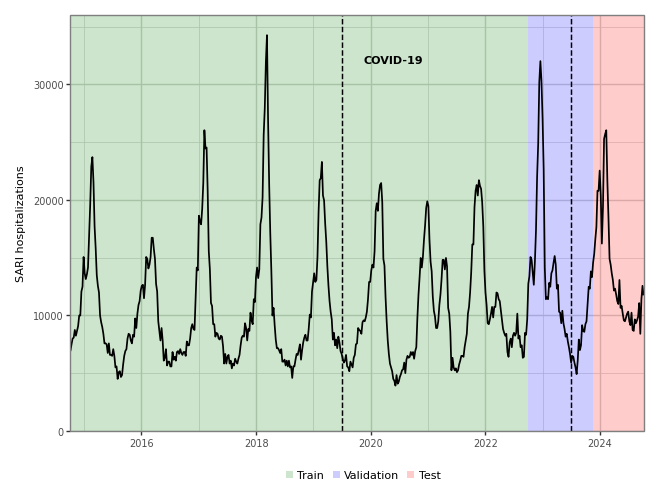

In [9]:
plot = (
    ggplot() +
    
    # Highlight train, validation and test period
    geom_rect(
        data=highlight_areas,
        mapping=aes(xmin="xmin", xmax="xmax", ymin=-float("inf"), ymax=float("inf"), fill="period"),
        alpha=0.2
    ) +
    
    # Vertical dashed line at the start of COVID-19
    geom_vline(
        xintercept=covid_start,
        linetype="dashed",
        color="black",
        size=0.6
    ) +
    geom_vline(
        xintercept=covid_end,
        linetype="dashed",
        color="black",
        size=0.6
    ) +
    
    # Label for COVID-19 start
    annotate(
        "text",
        x=covid_start + pd.Timedelta(weeks=20),
        y=df['icosari-sari-DE'].max() * 0.925,  # Slightly below the max y value for positioning
        label="COVID-19",
        ha="left",  # Align text to the left of the line
        va="bottom",  # Position text just above the line
        size=8,
        color="black",
        fontweight="bold"
    ) +
    
    geom_line(df, aes(x='date', y='icosari-sari-DE'), size=0.7) +
    
    labs(
        x="",
        y="SARI hospitalizations",
        fill="" 
    ) +
    scale_x_date(breaks=[pd.Timestamp('2016-01-01'), pd.Timestamp('2018-01-01'), pd.Timestamp('2020-01-01'), pd.Timestamp('2022-01-01'), pd.Timestamp('2024-01-01')],
                 labels=['2016', '2018', '2020', '2022', '2024'],
                 minor_breaks = pd.date_range(start='2015-01-01', end='2024-01-01', freq='YS')) +
    scale_y_continuous(limits=(0, df['icosari-sari-DE'].max()*1.05)) +
    scale_fill_manual(values={
        "Train": "green",
        "Validation": "blue",
        "Test": "red"
    }, limits=["Train", "Validation", "Test"]) + 
    
    theme_bw() +
    custom_theme() + 
    theme(legend_position="bottom",
          axis_text_x=element_text(size=7, rotation=0),
          axis_text_y=element_text(size=7),
          legend_text=element_text(size=8),
          axis_title=element_text(size=8),
          legend_key=element_blank(),
          legend_key_size=5,
          panel_grid_minor_x=element_line(size=0.5, color="lightgrey"),
          panel_grid_major_x=element_line(size=1, color="lightgrey"),
          panel_grid_minor_y=element_line(size=0.5, color="lightgrey"),
          panel_grid_major_y=element_line(size=1, color="lightgrey")) + 
    coord_cartesian(expand=False)
)

plot

In [10]:
plot.save("../figures/sari_periods.pdf", width = 80, height = 45, units="mm", dpi=600)

c:\Users\tm7202\Workspace\replication-sari-forecasting\.venv\Lib\site-packages\plotnine\ggplot.py:630: PlotnineWarning: Saving 80.0 x 45.00000000000001 mm image.
c:\Users\tm7202\Workspace\replication-sari-forecasting\.venv\Lib\site-packages\plotnine\ggplot.py:631: PlotnineWarning: Filename: ../figures/sari_periods.pdf


# Plot age groups

In [10]:
def custom_theme():
    return theme(
        plot_title=element_text(size=11),
        strip_text=element_text(size=10),
        legend_title=element_text(size=9),           
        legend_text=element_text(size=8),
        axis_title=element_text(size=10),
        axis_text_x=element_text(size=8),
        axis_text_y=element_text(size=8)
    )

In [11]:
df_long = pd.melt(df, id_vars=['date'], var_name='age_group', value_name='value')
df_long['age_group'] = df_long['age_group'].str.split('-', n=2).str[2]
df_long.age_group = df_long.age_group.replace({'DE': '00+'})
df_long['age_group'] = pd.Categorical(df_long['age_group'], categories=['00-04', '05-14', '15-34', '35-59', '60-79', '80+', '00+'], ordered=True) 
df_long = df_long[df_long.age_group != '00+']

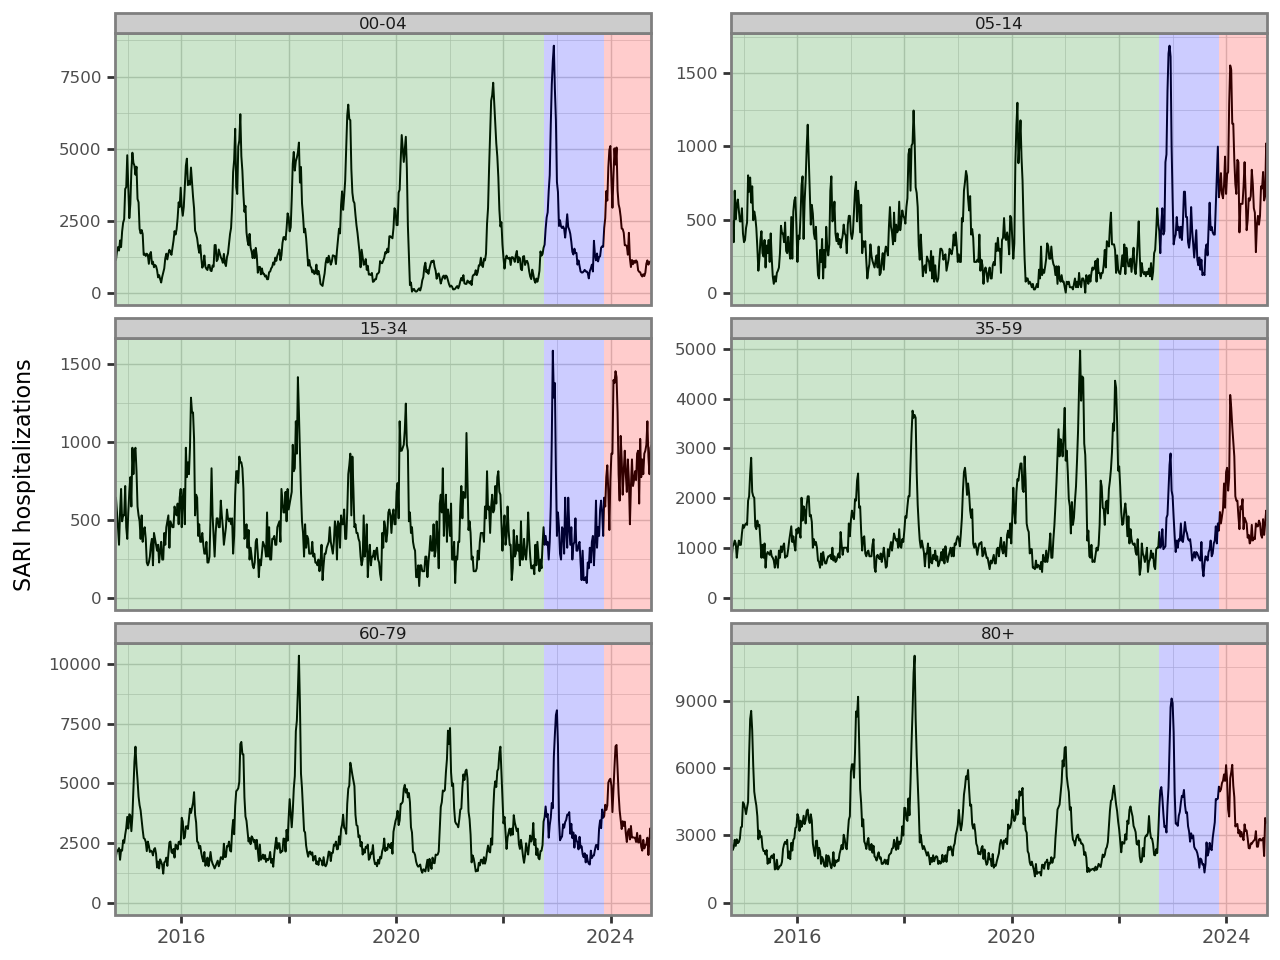

In [12]:
plot = (
    ggplot() +
    geom_line(df_long, aes(x='date', y='value'), size=0.4) +
    geom_rect(
        data=highlight_areas,
        mapping=aes(xmin="xmin", xmax="xmax", ymin=-float("inf"), ymax=float("inf"), fill="period"),
        alpha=0.2
    ) +
    facet_wrap('age_group', scales='free_y', ncol=2) +
    labs(
        x="",
        y="SARI hospitalizations",
        fill=''
    ) +
    scale_x_date(breaks=[pd.Timestamp('2016-01-01'), pd.Timestamp('2018-01-01'), pd.Timestamp('2020-01-01'), pd.Timestamp('2022-01-01'), pd.Timestamp('2024-01-01')],
             labels=['2016', '', '2020', '', '2024'],
             minor_breaks = pd.date_range(start='2015-01-01', end='2024-01-01', freq='YS'),
             expand=(0,0,0,0)) +
    scale_y_continuous(limits=(0, None)) +
    
    scale_fill_manual(values={
        "Train": "green",
        "Validation": "blue",
        "Test": "red"
    }, limits=["Train", "Validation", "Test"]) + # To order the legend
    
    theme_bw() +
    custom_theme() +
    theme(legend_position = 'none',
          strip_text=element_text(size=6, margin={'t': 1, 'b': 1}),
          axis_text_x=element_text(size=7, rotation=0),
          axis_text_y=element_text(size=6),
          legend_text=element_text(size=8),
          axis_title=element_text(size=8),
          legend_key=element_blank(),
          legend_key_size=5,
          panel_grid_minor_x=element_line(size=0.25, color="lightgrey"),
          panel_grid_major_x=element_line(size=0.5, color="lightgrey"),
          panel_grid_minor_y=element_line(size=0.25, color="lightgrey"),
          panel_grid_major_y=element_line(size=0.5, color="lightgrey")) 
)

plot

In [13]:
plot.save("../figures/sari_age.pdf", width = 80, height = 45, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 80.0 x 45.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/sari_age.pdf


# Different data versions

In [14]:
dates = ['2023-09-03', '2023-10-01', '2023-11-05', '2023-12-03', '2024-01-07']

In [15]:
def load_data_version(as_of):
    target_sari = load_target_series('sari', as_of, age_group='00+')
    latest_sari = load_latest_series('sari')

    return concatenate([latest_sari['icosari-sari-DE'].drop_after(target_sari[-4:].start_time()), target_sari[-4:]])

In [ ]:
dfs = []
for date in dates:
    print(date)
    df_temp = load_data_version(date)
    df_temp = df_temp['icosari-sari-DE'][pd.Timestamp('2023-07-01'):].to_dataframe().reset_index()
    df_temp['data_version'] = date
    dfs.append(df_temp)

2023-09-03


2023-10-01


2023-11-05


2023-12-03


2024-01-07


In [17]:
df = pd.concat(dfs)

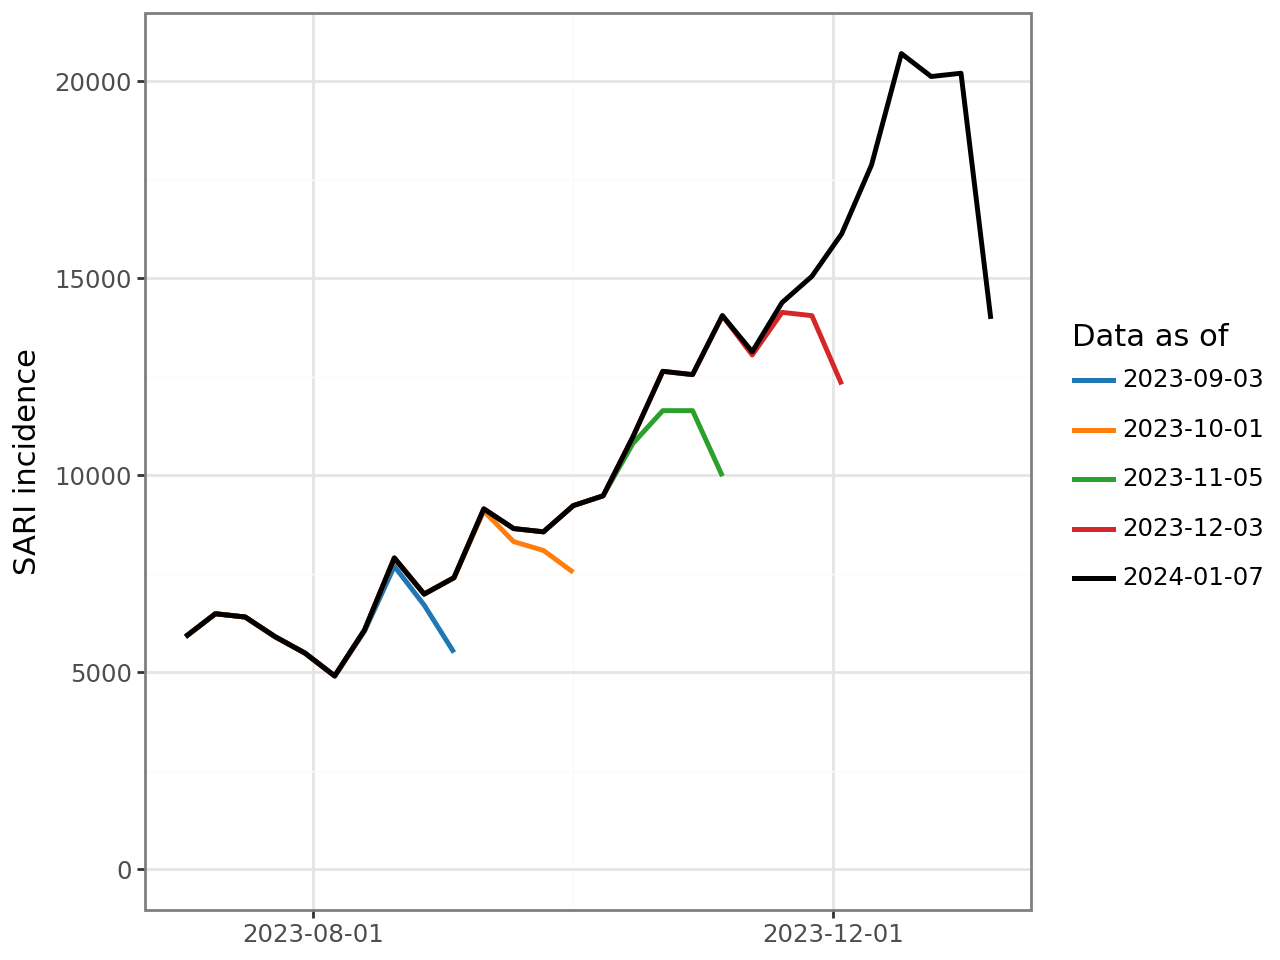

In [18]:
plot = (
    ggplot() +
    geom_line(df, aes(x='date', y='icosari-sari-DE', color='data_version'), size=1) +
    
    # Customize labels and scales
    labs(
        x="",
        y="SARI incidence",
        color="Data as of"
    ) +
    scale_x_date( # date_breaks='4 month', minor_breaks='1 month'
     breaks=[pd.Timestamp('2023-08-01'), pd.Timestamp('2023-12-01')]
    ) +
    scale_y_continuous(limits=(0, None)) +
    
    # Define colors for each period in the legend
    scale_color_manual(values={
        '2023-09-03': '#1f77b4',  # Blue
        '2023-10-01': '#ff7f0e',  # Orange
        '2023-11-05': '#2ca02c',  # Green
        '2023-12-03': '#d62728',  # Red
        '2024-01-07': '#000000',  # Black
    }, limits=dates) + # To order the legend
    
    # Customize theme
    theme_bw() +
    theme(legend_position="right",
          legend_key=element_blank())
)

plot

In [19]:
plot.save("../figures/revision.pdf", width = 90, height = 60, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 90.00000000000001 x 60.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/revision.pdf
